## Assignment 1
## FIT5202 - Data Processing for Big Data
Student name: Nandin-Erdene Batsaikhan <br/>
Student ID: 29448026 <br/>
Tutorial time: 4pm Wednesday <br/>
Tutor name: Tooba Jalalidil

## Part B: Analysing CSV Data

In this part, crime data from South Australia will be analysed. The dataset reflects reported incidents of crime (suburb-based crime statistics for crimes against the person and crimes against property) that occurred in South Australia since 2010.

Dataset is:
* Crime_Statistics_SA_2010_present.csv

Libraries used:
* os (for connect mongodb with spark)
* SparkConf, SparkContext (for application configuration and for creating entry points to spark)
* SparkSession (for mongodb)
* sql.functions (for user-defined function, findind year and dayofweek from date)
* datetime (for converting string column type into date column type)
* sql.types (for DateType())
* matplotlib (for plotting graphs to explore data)

In [2]:
# Uncomment the command below to install matplotlib package if it is needed
# !pip install matplotlib

In [26]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.mongodb.spark:mongo-spark-connector_2.11:2.4.0 pyspark-shell'
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from datetime import datetime
from pyspark.sql.types import DateType
import matplotlib.pyplot as plt
# Display graphs in jupyter notebook
%matplotlib inline


#### Step 01: Import ​pyspark ​and initialize Spark

In [27]:
# If there is an existing spark context, we will use reuse it because 
# it is impossible to run multiple SparkContexts at the same time.
sc = SparkContext.getOrCreate()

# local[*] indicates that run Spark locally with as many working processors as logical cores on the machine
if sc is None:
    conf = SparkConf().setMaster("local[*]").setAppName("Analysing CSV Data")
    sc = SparkContext(conf = conf)

my_spark = SparkSession(sparkContext = sc)\
            .builder\
            .appName('Analysing CSV Data')\
            .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.11:2.4.0')\
            .config('spark.mongodb.input.uri', 'mongodb://127.0.0.1/fit5202_db.ass1b_coll')\
            .config('spark.mongodb.output.uri', 'mongodb://127.0.0.1/fit5202_db.ass1b_coll')\
            .getOrCreate()

#### Step 02: Create Dataframe

In [28]:
# Create a data frame and provide data as source as CSV file
df = my_spark.read.csv('Crime_Statistics_SA_2010_present.csv', inferSchema = True, header = True)
print('The number of records in the dataframe:', df.count())

The number of records in the dataframe: 727408


#### Step 03: Write to Database

In [29]:
# Read the CSV file and insert all the records into MongoDB in overwrite mode
df.write.format("com.mongodb.spark.sql.DefaultSource").mode("overwrite").save()

#### Step 04: Read from Database

In [30]:
# Create the crime_df data frame from the MongoDB collection
crime_df = my_spark.read.format("com.mongodb.spark.sql.DefaultSource").load()
# Display the schema of the crime_df data frame
crime_df.printSchema()

root
 |-- Offence Count: integer (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Reported Date: string (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



#### Step 05: Calculate the statistics of numeric and string columns

In [31]:
# Computes statistics for string and numeric columns, including count, mean, stddev, min and max
crime_df.describe(['Reported Date', 'Offence Count']).show()


+-------+-------------+------------------+
|summary|Reported Date|     Offence Count|
+-------+-------------+------------------+
|  count|       727407|            727407|
|   mean|         null|1.1715174585892079|
| stddev|         null|0.5787050930378116|
|    min|    1/01/2011|                 1|
|    max|    9/12/2018|                28|
+-------+-------------+------------------+



If we check statistics of 'Reported Date' column, we identify that it gives us wrong min and max value because the column type is string. The describe(cols) function computes correct on numeric columns.

#### Step 06: Change the data type of a column

In [32]:
# Define user-defined function which converts string into date type
convert_to_date = f.udf(lambda x: datetime.strptime(x, '%d/%m/%Y') if x is not None else None, DateType())
# The function withColumn is called to replace a column to the data frame since the column name exists before
altered_crime_df = crime_df.withColumn('Reported Date', convert_to_date('Reported Date'))
# Display the schema of altered_crime_df data frame to ensure if the data type of a column has changed
altered_crime_df.printSchema()

root
 |-- Offence Count: integer (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Reported Date: date (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



#### Step 07: Preliminary data analysis

In [33]:
# How many level 2 offences are there? Display the list of level 2 offences.
level2_offences_df = altered_crime_df.filter(altered_crime_df['Offence Level 2 Description'].isNotNull())\
                                        .select('Offence Level 2 Description').distinct()
print('Level 2 offences: ', level2_offences_df.count())
level2_offences_df.show(truncate = False)

Level 2 offences:  9
+------------------------------------+
|Offence Level 2 Description         |
+------------------------------------+
|ROBBERY AND RELATED OFFENCES        |
|PROPERTY DAMAGE AND ENVIRONMENTAL   |
|SEXUAL ASSAULT AND RELATED OFFENCES |
|HOMICIDE AND RELATED OFFENCES       |
|ACTS INTENDED TO CAUSE INJURY       |
|SERIOUS CRIMINAL TRESPASS           |
|OTHER OFFENCES AGAINST THE PERSON   |
|FRAUD DECEPTION AND RELATED OFFENCES|
|THEFT AND RELATED OFFENCES          |
+------------------------------------+



In [36]:
# What is the number of offences against the person?
offences_against_the_person = altered_crime_df.filter(altered_crime_df['Offence Level 1 Description'] \
                                                      == 'OFFENCES AGAINST THE PERSON')\
                                                .agg(f.sum('Offence Count').alias('Total Offence Count'))
offences_against_the_person.show()

+-------------------+
|Total Offence Count|
+-------------------+
|             175644|
+-------------------+



In [37]:
# How many serious criminal tresspasses with more than 1 offence count?
serious_criminal_tresspasses = altered_crime_df.filter((altered_crime_df['Offence Level 2 Description'] == \
                                                        'SERIOUS CRIMINAL TRESPASS') \
                                                       & (altered_crime_df['Offence Count'] > 1))
print('Serious criminal tresspasses with more than 1 offence count:', serious_criminal_tresspasses.count())

Serious criminal tresspasses with more than 1 offence count: 8579


In [38]:
# What percentage of crimes are offences against the property?
offences_against_the_property = altered_crime_df.filter(altered_crime_df['Offence Level 1 Description'] == \
                                                        'OFFENCES AGAINST PROPERTY')
sum_offences_against_the_property = offences_against_the_property.agg(f.sum('Offence Count')\
                                                                      .alias('Total Offence Count')).collect()[0]
sum_offences_altered_crime_df = altered_crime_df.agg(f.sum('Offence Count')\
                                                     .alias('Total Offence Count')).collect()[0]
print('Percentage of offences against the property:', \
      (sum_offences_against_the_property['Total Offence Count']*100)/\
      (sum_offences_altered_crime_df['Total Offence Count']), '%')

Percentage of offences against the property: 79.3886196416208 %


#### Step 08: Exploratory data analysis

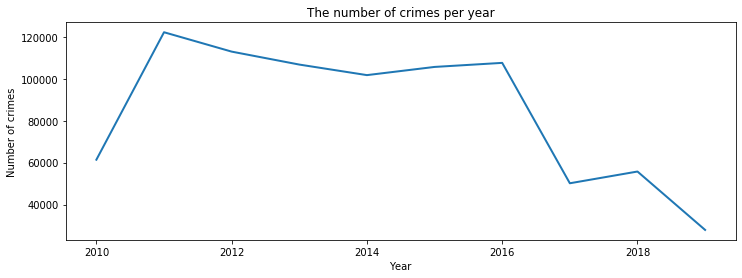

In [39]:
# Number of crimes per year
# Prepare data
year_df = altered_crime_df.withColumn('Year', f.year('Reported Date'))
crime_by_year_df = year_df.filter(year_df['Year'].isNotNull())\
                            .groupBy('Year')\
                            .agg(f.sum('Offence Count').alias('Number of Crimes'))\
                            .orderBy('Year').collect()
years = [row['Year'] for row in crime_by_year_df]
number_of_crimes = [row['Number of Crimes'] for row in crime_by_year_df]

# Plot
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(years, number_of_crimes, linewidth=2)
ax.set_title('The number of crimes per year')
ax.set_xlabel('Year')
ax.set_ylabel('Number of crimes')
plt.show()

From 2010 to the begining of 2012, the number of crimes increased significantly. Then, it decreased gradually until 2014 but after 2014, it rose slightly until 2016. Between 2016 and around 2017, the number of crimes dropped rapidly again. After that, it increased slowly until 2018 and then decreased sharpedly. The peak point was in around beginning of 2012 and it may keep continuing to go down.

+-----+----------------+
|Month|Number of Crimes|
+-----+----------------+
|    1|           77516|
|    2|           70429|
|    3|           74931|
|    4|           60037|
|    5|           64246|
|    6|           60687|
|    7|           70954|
|    8|           72839|
|    9|           72595|
|   10|           77153|
|   11|           75191|
|   12|           75592|
+-----+----------------+



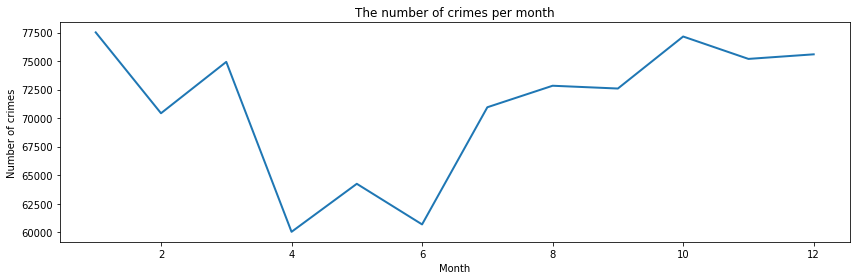

In [40]:
# Number of crimes per month
# Prepare data
month_df = altered_crime_df.withColumn('Month', f.month('Reported Date'))
crime_by_month_df = month_df.filter(month_df['Month'].isNotNull())\
                            .groupBy('Month')\
                            .agg(f.sum('Offence Count').alias('Number of Crimes'))\
                            .orderBy('Month')
crime_by_month_df.show()
months = [row['Month'] for row in crime_by_month_df.collect()]
number_of_crimes = [row['Number of Crimes'] for row in crime_by_month_df.collect()]

# Plot
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(months, number_of_crimes, linewidth=2)
ax.set_title('The number of crimes per month')
ax.set_xlabel('Month')
ax.set_ylabel('Number of crimes')
plt.tight_layout()
plt.show()

In 'Number of crimes per month' line graph, the number of crimes is increased rapidly from June until January and from January to April, it is decreased significantly. The April and June are may more safety months compared with other months but October, December and January could be dangerous in terms of crime rate.

+---------------------------+----------------+
|Suburb-Postcode            |Number of Crimes|
+---------------------------+----------------+
|ADELAIDE-5000              |46701           |
|PORT AUGUSTA-5700          |13711           |
|MOUNT GAMBIER-5290         |13709           |
|MURRAY BRIDGE-5253         |12919           |
|MORPHETT VALE-5162         |12569           |
|SALISBURY-5108             |10806           |
|PORT LINCOLN-5606          |10779           |
|ELIZABETH-5112             |10731           |
|NOT DISCLOSED-NOT DISCLOSED|9375            |
|DAVOREN PARK-5113          |8082            |
|PARAFIELD GARDENS-5107     |8040            |
|OAKLANDS PARK-5046         |7792            |
|PARALOWIE-5108             |7261            |
|PROSPECT-5082              |7234            |
|PORT PIRIE-5540            |7155            |
|MODBURY-5092               |7041            |
|SMITHFIELD-5114            |7000            |
|SALISBURY NORTH-5108       |6538            |
|WHYALLA STUA

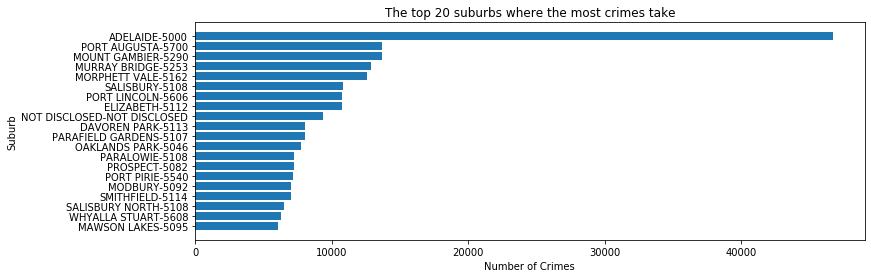

In [41]:
# Where the most crimes take place? Find the top 20 suburbs (which would also display postcode e.g. Caulfield-3162)
# Prepare data
suburb_crimes_df = altered_crime_df.groupBy('Suburb - Incident', 'Postcode - Incident')\
                                    .agg(f.sum('Offence Count').alias('Number of Crimes'))\
                                    .orderBy('Number of Crimes', ascending=False)
top20_suburb_crimes_df = suburb_crimes_df.limit(20)\
                                            .select(f.concat(suburb_crimes_df['Suburb - Incident'], f.lit('-')\
                                                             , suburb_crimes_df['Postcode - Incident'])\
                                                    .alias('Suburb-Postcode'), suburb_crimes_df['Number of Crimes'])\
                                            .orderBy('Number of Crimes', ascending=False)
top20_suburb_crimes_df.show(truncate=False)
suburbs = [row['Suburb-Postcode'] for row in top20_suburb_crimes_df.collect()]
number_of_crimes = [row['Number of Crimes'] for row in top20_suburb_crimes_df.collect()]

# Plot
fig, ax = plt.subplots(figsize=(12,4))
bar_width = 0.8
ax.barh(suburbs, number_of_crimes, bar_width, align='center', color='C0')
ax.set_ylabel('Suburb')
ax.set_xlabel('Number of Crimes')
ax.set_title('The top 20 suburbs where the most crimes take')
plt.gca().invert_yaxis()
plt.show()


Based on the most crimes take place bar chart, it is clear that Adelaide-5000 is the most crimes take place because the  number of crimes is almost 4 times greater than second suburb. Apart from Adelaide-5000, the amount of difference of the number crimes are comparable. We may need to check Adelaide-5000's statistics related to the crimes to ensure if it is not outlier.

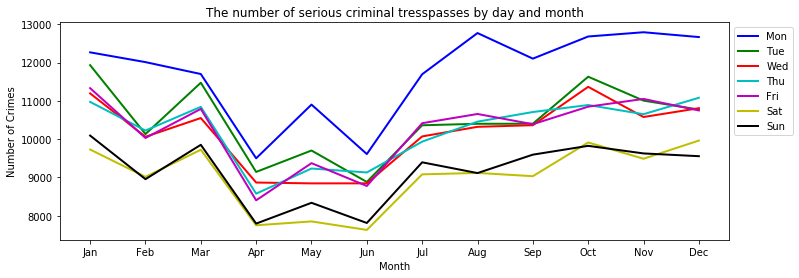

In [43]:
# Find the number of serious criminal trespasses by day and month
serious_criminal_trespass = altered_crime_df.filter(altered_crime_df['Offence Level 1 Description'] \
                                                    == 'SERIOUS CRIMINAL TRESPASS')
# Dayofweek returns the day of the week for data/timestamp (1 - Sunday, 2-Monday..)
serious_criminal_trespass = altered_crime_df.withColumn('Month', f.month('Reported Date'))\
                                            .withColumn('Day of week', f.dayofweek('Reported Date'))
serious_criminal_trespass = serious_criminal_trespass.groupBy('Month', 'Day of week')\
                                                        .agg(f.sum('Offence count').alias('Number of Crimes'))\
                                                        .orderBy('Month', 'Day of week').collect()

# Prepare data
number_of_crimes_2 = [row['Number of Crimes'] for row in serious_criminal_trespass if row['Day of week'] == 2]
number_of_crimes_3 = [row['Number of Crimes'] for row in serious_criminal_trespass if row['Day of week'] == 3]
number_of_crimes_4 = [row['Number of Crimes'] for row in serious_criminal_trespass if row['Day of week'] == 4]
number_of_crimes_5 = [row['Number of Crimes'] for row in serious_criminal_trespass if row['Day of week'] == 5]
number_of_crimes_6 = [row['Number of Crimes'] for row in serious_criminal_trespass if row['Day of week'] == 6]
number_of_crimes_7 = [row['Number of Crimes'] for row in serious_criminal_trespass if row['Day of week'] == 7]
number_of_crimes_1 = [row['Number of Crimes'] for row in serious_criminal_trespass if row['Day of week'] == 1]
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plot
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(months, number_of_crimes_2, label='Mon', color='b', linewidth=2)
ax.plot(months, number_of_crimes_3, label='Tue', color='g', linewidth=2)
ax.plot(months, number_of_crimes_4, label='Wed', color='r', linewidth=2)
ax.plot(months, number_of_crimes_5, label='Thu', color='c', linewidth=2)
ax.plot(months, number_of_crimes_6, label='Fri', color='m', linewidth=2)
ax.plot(months, number_of_crimes_7, label='Sat', color='y', linewidth=2)
ax.plot(months, number_of_crimes_1, label='Sun', color='k', linewidth=2)
ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Month')
ax.legend(bbox_to_anchor=(1,1))
ax.set_title('The number of serious criminal tresspasses by day and month')
plt.show()


The correlation between number of crimes and month is similar to our 'The number of crimes per month' line graph which we plotted in task 2 of Step 8. However, we can see more detailed information from this graph since it diplays comparison of week days. According to this graph, the most of crimes are happened on Monday while the number of crimes becomes lesser at weekend. Between Tuesday and Friday, the number of crimes are comparable.

## References

- Koehrsen W. (2018, March 24). *Histograms and Density Plots in Python*. Retrieved from https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0
- Reyes H. (2016, June 28) *Convert pyspark string to date format* [Response to]. Retrieved from https://stackoverflow.com/questions/38080748/convert-pyspark-string-to-date-format
- desertnaut. (2017, September 6) *Concatenate columns in Apache Spark DataFrame* [Response to]. Retrieved from https://stackoverflow.com/questions/31450846/concatenate-columns-in-apache-spark-dataframe
